# AI TRAFFIC SIGNS RECOGNITION

## Importing the libraries

In [40]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [2]:
data_dir = 'gtsrb'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [3]:
NUM_CATEGORIES = len(os.listdir(data_dir))
NUM_CATEGORIES

43

In [4]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Finding Total Classes and Visualization for it

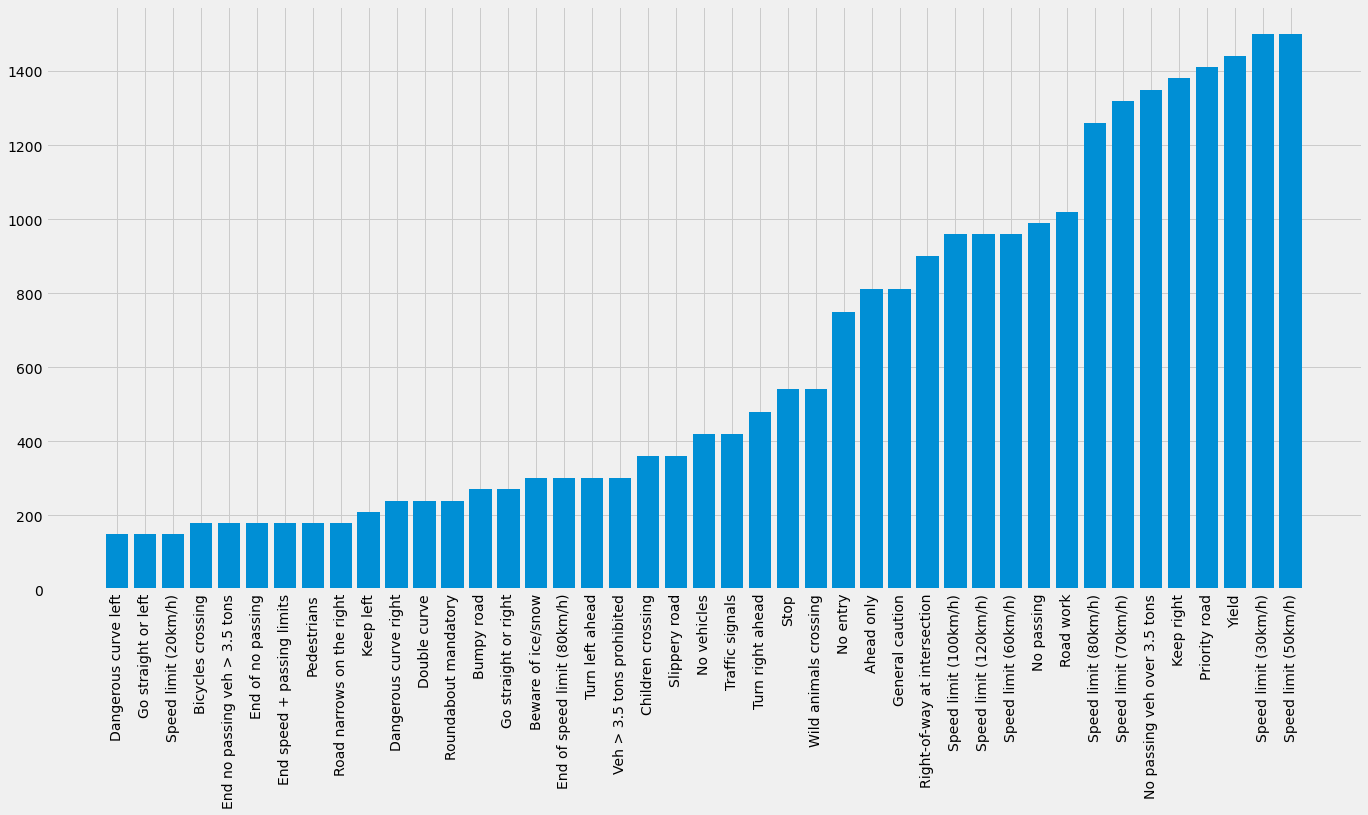

In [5]:
folders = os.listdir(data_dir)

data_number = []
class_num = []

for folder in folders:
    data_files = os.listdir(data_dir + '/' + folder)
    data_number.append(len(data_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(data_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
data_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, data_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

## Loading the dataset and resize the images

Time to load the data. We will use pandas to load signnames.csv, and pickle to load the train, validation and test pickle files. After extraction of data, it is then split using the dictionary labels “features” and “labels”.

In [6]:
data = []
labels = []
# Retrieving the images and their labels
for i in range(NUM_CATEGORIES):
    path = os.path.join(data_dir, str(i))
    images = os.listdir(path)

    for a in images:
        try:
            #image = Image.open(path + '\\' + a)
            image = cv2.imread(path + '\\' + a)
            image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), 3)
            #image = image.resize((IMG_WIDTH, IMG_HEIGHT))
            image = np.array(image)
            # (width, height , 3)
            #print(image.shape)
            # sim = Image.fromarray(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")
# Converting lists into numpy arrays
images = np.array(data)
labels = np.array(labels)

In [7]:
print(images.shape)

(26640, 30, 30, 3)


## Splitting data 

After reshaping the arrays, it’s time to split them into training and testing data and the test and validate size will be 30% from whole data.

In [8]:
TEST_SIZE = 0.1
Train_SIZE = 0.7
Validate_SIZE = 0.2
labels = tf.keras.utils.to_categorical(labels)
x_train, x_test, y_train, y_test = train_test_split(
        np.array(images), np.array(labels), train_size=Train_SIZE+Validate_SIZE, test_size=TEST_SIZE, random_state=42
    )

We want to standardize our dataset.

In [9]:
X_trainn = x_train/255 
x_testt = x_test/255

print("X_train.shape", X_trainn.shape)
print("X_test.shape", x_testt.shape)
print("y_train.shape", y_train.shape)
print("y_test.shape", y_test.shape)

X_train.shape (23975, 30, 30, 3)
X_test.shape (2664, 30, 30, 3)
y_train.shape (23975, 43)
y_test.shape (2664, 43)


## Building the model

Here the CNN model's structure is defined. Regarding the loss function the categorical crossentropy is used, and the ADAM is selection for the network optimization.

As we have 70% training of images in the dataset, we are setting EPOCHS as 10. The model contains two Conv2D layers followed by one MaxPooling2D layer. This is done two times for the effective extraction of features, which is followed by the Dense layers. A dropout layer of 0.5 is added to avoid overfitting the data.

In [10]:
def get_model(X_train):
    """
    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    # Building the model
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=X_train.shape[1:]))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(43, activation='softmax'))

    # Compilation of the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return  model

### compiled neural network and save model

In [11]:
# Get a compiled neural network
model = get_model(x_train)
# Save model to file
model.save("Saved_model.h5")

### Model Summary and plot the model

In [12]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0

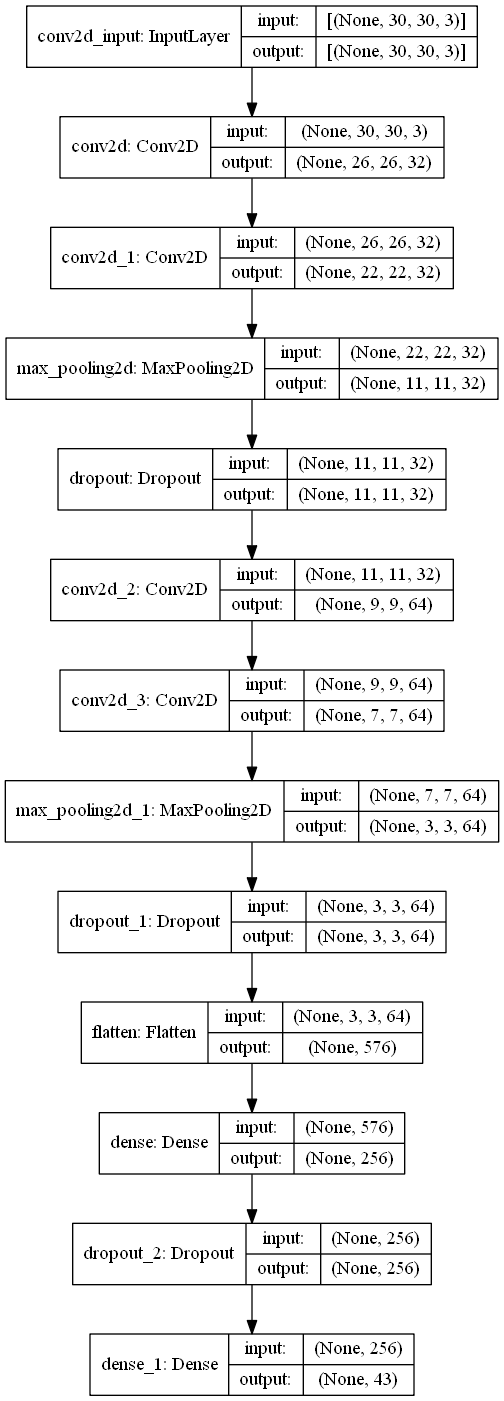

In [13]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Fit the data and training the model

In [14]:
my_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2),
        tf.keras.callbacks.ModelCheckpoint(filepath='Saved_model.h5'),
        tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ]
EPOCHS = 10
# Fit model on training data
history =model.fit(x_train, y_train,batch_size=32, epochs=EPOCHS, validation_split=0.2, verbose=1, callbacks=my_callbacks)

Epoch 1/10
600/600 [==============================] - 47s 77ms/step - loss: 4.3449 - accuracy: 0.2031 - val_loss: 1.0188 - val_accuracy: 0.7193
Epoch 2/10
600/600 [==============================] - 45s 75ms/step - loss: 1.2885 - accuracy: 0.6331 - val_loss: 0.4695 - val_accuracy: 0.8861
Epoch 3/10
600/600 [==============================] - 45s 75ms/step - loss: 0.7551 - accuracy: 0.7767 - val_loss: 0.2654 - val_accuracy: 0.9295
Epoch 4/10
600/600 [==============================] - 45s 76ms/step - loss: 0.5655 - accuracy: 0.8321 - val_loss: 0.2510 - val_accuracy: 0.9218
Epoch 5/10
600/600 [==============================] - 46s 77ms/step - loss: 0.4136 - accuracy: 0.8776 - val_loss: 0.1262 - val_accuracy: 0.9654
Epoch 6/10
600/600 [==============================] - 45s 75ms/step - loss: 0.3405 - accuracy: 0.8994 - val_loss: 0.1271 - val_accuracy: 0.9658
Epoch 7/10
600/600 [==============================] - 45s 75ms/step - loss: 0.3238 - accuracy: 0.9024 - val_loss: 0.1203 - val_accuracy:

## Evaluating the model

In [16]:
saved_model = load_model('my_model.h5')
_, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.988, Test: 0.980


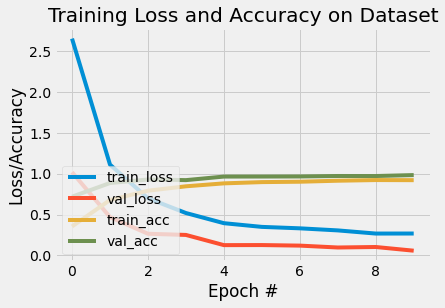

In [17]:
# plotting graphs for accuracy
plt.figure()
N = np.arange(0, EPOCHS)
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [20]:
x_test = np.array(x_test)
pred = model.predict_classes(x_test)
print("[INFO] evaluating network...")
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),predictions.argmax(axis=1), target_names=classes))

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[INFO] evaluating network...
                               precision    recall  f1-score   support

                   Bumpy road       1.00      1.00      1.00        10
        Speed limit (100km/h)       0.98      0.97      0.97       136
                Slippery road       0.98      0.97      0.97       159
              Turn left ahead       1.00      0.98      0.99       101
End no passing veh > 3.5 tons       0.98      1.00      0.99       125
         Speed limit (80km/h)       0.96      0.98      0.97       134
         Roundabout mandatory       1.00      1.00      1.00        33
             Turn right ahead       0.98      0.95      0.96        94
         Speed limit (20km/h)       0.95      0.99      0.97        94
                    Keep left       0.98      0.99      0.99       109
         Dangerous curve left       0.98      0.99      0.99       124
         Speed limit (30km/h)       0.99      1.00      0.99        91
                Priority road       0.99      0

In [38]:
cm =confusion_matrix(np.argmax(y_test, axis=1), pred)

<AxesSubplot:>

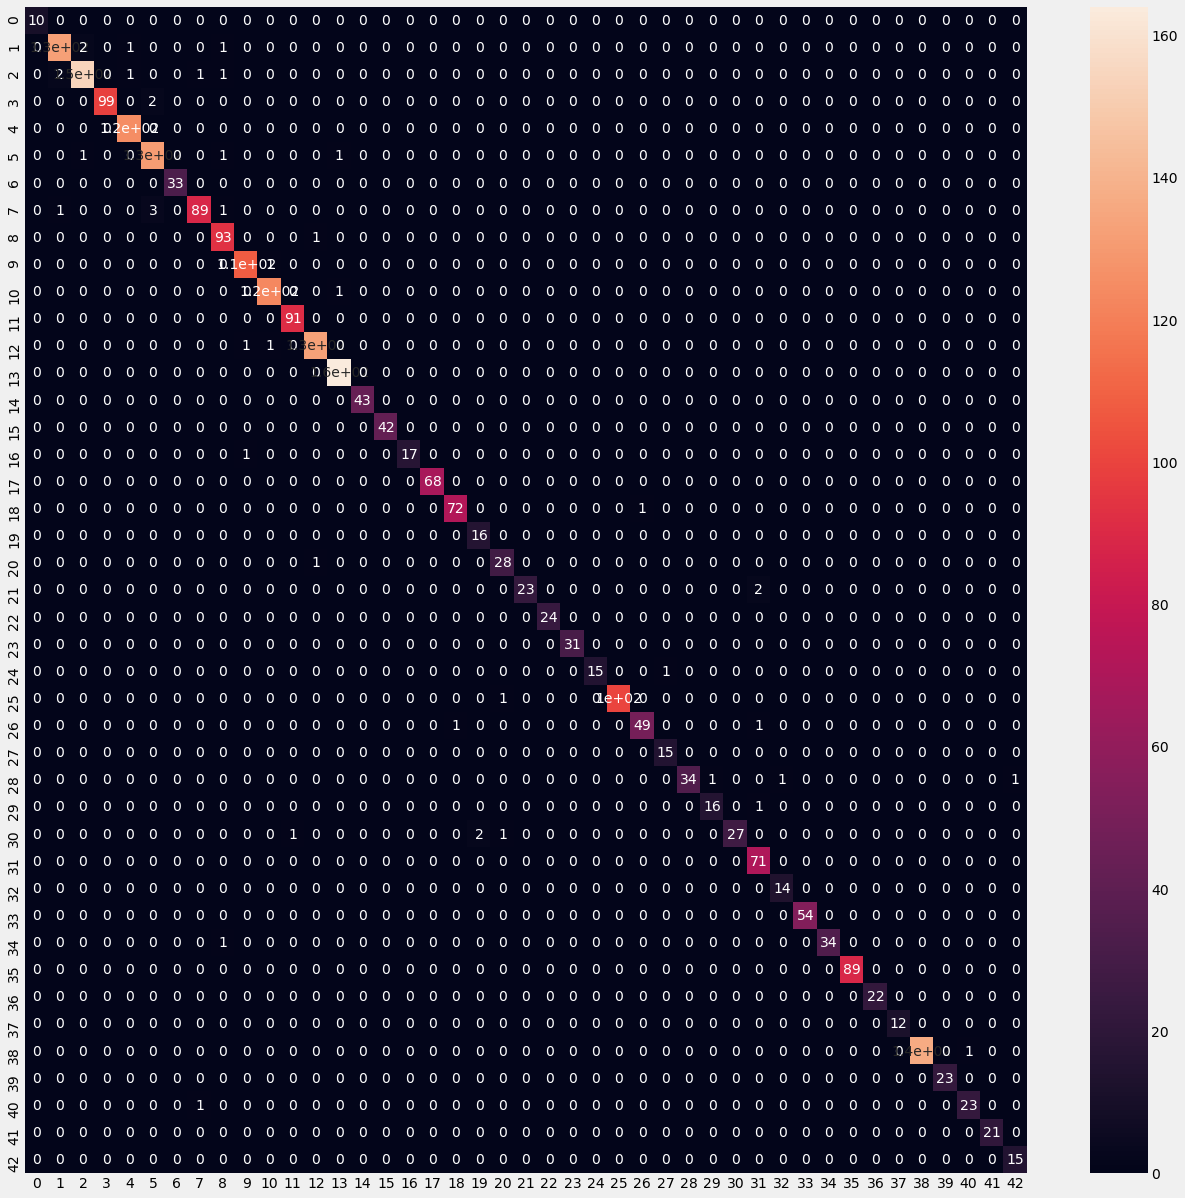

In [43]:
plt.figure(figsize = (20,20))
sns.heatmap(cm, annot=True)

## Predictions some images using GUI

In [66]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image

# Load your model
model = load_model('my_model.h5') # Path to your model

# Initialise GUI
top=tk.Tk()
# Window dimensions (800x600)
top.geometry('800x600')
# Window title
top.title('Traffic sign classification')
# Window background color
top.configure(background='#CDCDCD')
# Window label
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
# Sign image
sign_image = Label(top)


# Function to classify image
def classify(file_path):
    global label_packed
    # Open the image file path
    image = Image.open(file_path)
    # Resize the image
    image = image.resize((30,30))
    # Inserts a new axis that will appear at the axis position in the expanded array shape
    image = np.expand_dims(image, axis=0)
    # Convert to numpy array
    image = np.array(image)
    # Make prediction
    pred = model.predict_classes([image])[0]
    sign = classes[pred+1]
    print(sign)
    label.configure(foreground='#011638', text=sign) 
    
# Function to show the "classify" button
def show_classify_button(file_path):
    # Create the button
    classify_b=Button(top,text="Classify Image",command=lambda: classify(file_path),padx=10,pady=5)
    # Configure button colors
    classify_b.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
    # Configure button place (location)
    classify_b.place(relx=0.79,rely=0.46)
    
# Function to upload image
def upload_image():
    try:
        # Path of the image
        file_path=filedialog.askopenfilename()
        # Open file path
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),(top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)
    except:
        pass
    
# Create "Upload" button
upload=Button(top,text="Upload an image",command=upload_image,padx=10,pady=5)
# "Upload" button colors and font
upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
# Button location
upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
# Window title text
heading = Label(top, text="Know Your Traffic Sign",pady=20, font=('arial',20,'bold'))
# Window colors
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()

Speed limit (70km/h)
Dangerous curve left
Road work
Wild animals crossing
